In [13]:
import pickle
import numpy as np
from scipy import stats
from scipy import special
from scipy import integrate
from scipy.spatial.transform import Rotation
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Gaussian Mean Difference

## Calibrating Maximal Mean Difference

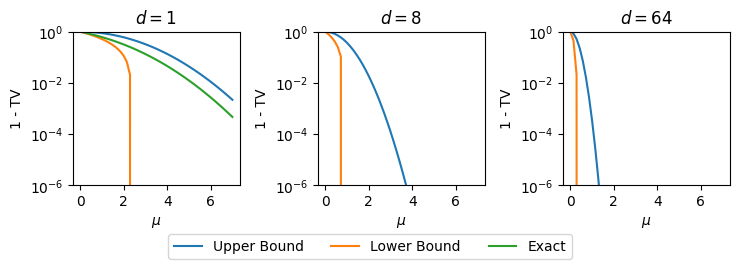

In [18]:
def gaussian_hellinger_sq(mu1, mu2, dim):
    dotterm = np.sum((mu1 - mu2)**2 * dim)
    expterm = np.exp(-1 / 8 * dotterm)
    return 1 - expterm

mu2s = np.linspace(0, 7)
fig, axes = plt.subplots(1, 3, figsize=(3 * 2.5, 2.5))
for i, dim in enumerate([1, 8, 64]):
    ax = axes[i]
    hellinger_sqs = np.array([gaussian_hellinger_sq(0, mu2, dim) for mu2 in mu2s])
    ax.plot(mu2s, 1 - hellinger_sqs, label="Upper Bound")
    ax.plot(mu2s, 1 - np.sqrt(2) * np.sqrt(hellinger_sqs), label="Lower Bound")

    if dim == 1:
        tvs = [
            integrate.quad(
                lambda x: 0.5 * np.abs(stats.norm.pdf(x, loc=0, scale=1) - stats.norm.pdf(x, loc=mu2, scale=1)), 
                -np.inf, np.inf
            )[0]
            for mu2 in mu2s
        ]
        ax.plot(mu2s, 1 - np.array(tvs), label="Exact")

    ax.set_ylabel("1 - TV")
    ax.set_xlabel("$\mu$")
    ax.set_title("$d = {}$".format(dim))
    ax.set_ylim((0.000001, 1.0))
    ax.set_yscale("log")
    if i == 0:
        leg_info = ax.get_legend_handles_labels()

fig.legend(*leg_info, loc="upper center", bbox_to_anchor=(0.5, 0.07), ncol=3)
plt.tight_layout()
plt.savefig("../figures/gaussian_mean_difference_tv_visualisation.pdf", bbox_inches="tight")
plt.show()

In [3]:
gaussian_hellinger_sq(0, 1, 1)

np.float64(0.11750309741540454)

In [4]:
1 - np.exp(-1 / 4 * (0 - 1)**2 / (2))

np.float64(0.11750309741540454)

## Visualising Distributions

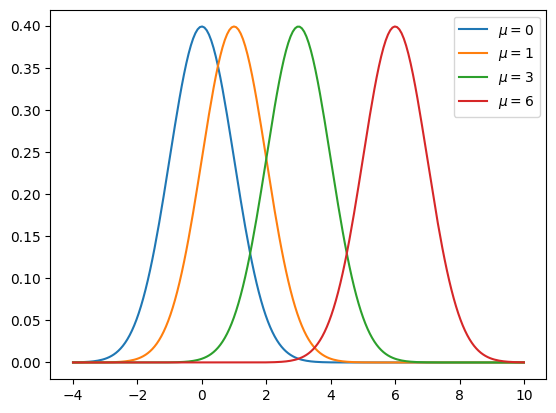

In [5]:
xs = np.linspace(-4, 10, 200)
plt.plot(xs, stats.norm.pdf(xs, loc=0, scale=1), label="$\mu = 0$")
plt.plot(xs, stats.norm.pdf(xs, loc=1, scale=1), label="$\mu = 1$")
plt.plot(xs, stats.norm.pdf(xs, loc=3, scale=1), label="$\mu = 3$")
plt.plot(xs, stats.norm.pdf(xs, loc=6, scale=1), label="$\mu = 6$")
plt.legend()
plt.show()

# Gaussian Standard Deviation Difference

## Calibrating Maximal Standard Deviation Difference

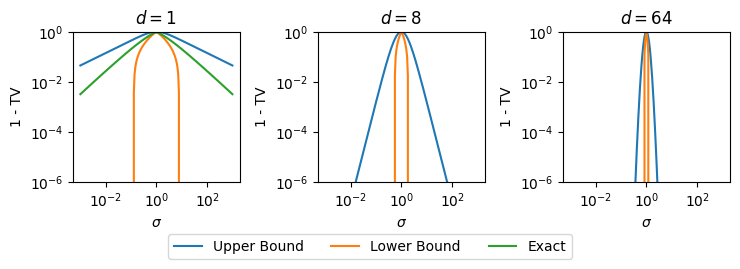

In [4]:
def gaussian_hellinger_sq_with_std_difference(sigma1, sigma2, dim):
    log_numerator = np.log(sigma1) * (2 * dim / 4) + np.log(sigma2) * (2 * dim / 4)
    log_denomenator = dim / 2 * np.log((sigma1**2 + sigma2**2) / 2)
    return 1 - np.exp(log_numerator - log_denomenator)

vs = np.logspace(-3, 3, 200, base=10)
low_res_vs = np.logspace(-3, 3, 50, base=10)
sigma1 = 1
fig, axes = plt.subplots(1, 3, figsize=(3 * 2.5, 2.5))
for i, dim in enumerate([1, 8, 64]):
    ax = axes[i]
    hellinger_sqs = np.array([gaussian_hellinger_sq_with_std_difference(sigma1, sigma1 * v, dim) for v in vs])
    ax.plot(vs, 1 - hellinger_sqs, label="Upper Bound")
    ax.plot(vs, 1 - np.sqrt(2) * np.sqrt(hellinger_sqs), label="Lower Bound")

    if dim == 1:
        tvs = [
            integrate.quad(
                lambda x: 0.5 * np.abs(stats.norm.pdf(x, loc=0, scale=sigma1) - stats.norm.pdf(x, loc=0, scale=sigma1 * v)), 
                -np.inf, np.inf
            )[0]
            for v in low_res_vs
        ]
        ax.plot(low_res_vs, 1 - np.array(tvs), label="Exact")

    # ax.axhline(0, color="grey", linestyle="dashed")
    ax.set_ylabel("1 - TV")
    ax.set_xlabel("$\sigma$")
    ax.set_title("$d = {}$".format(dim))
    ax.set_ylim((0.000001, 1.0))
    ax.set_yscale("log")
    ax.set_xscale("log")
    if i == 0:
        leg_info = ax.get_legend_handles_labels()

fig.legend(*leg_info, loc="upper center", bbox_to_anchor=(0.5, 0.07), ncol=3)
plt.tight_layout()
plt.savefig("../figures/gaussian_std_difference_tv_visualisation.pdf", bbox_inches="tight")
plt.show()

In [7]:
gaussian_hellinger_sq_with_std_difference(1, 2, 1)

np.float64(0.10557280900008414)

In [8]:
1 - np.sqrt((2 * 1 * 2) / (1**2 + 2**2))

np.float64(0.10557280900008414)

## Visualising Distributions

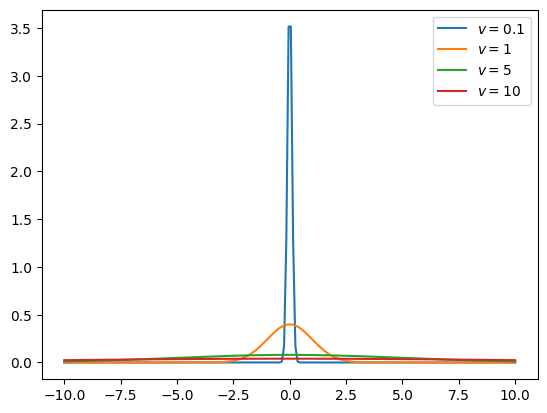

In [9]:
xs = np.linspace(-10, 10, 200)
plt.plot(xs, stats.norm.pdf(xs, loc=0, scale=0.1), label="$v = 0.1$")
plt.plot(xs, stats.norm.pdf(xs, loc=0, scale=1), label="$v = 1$")
plt.plot(xs, stats.norm.pdf(xs, loc=0, scale=5), label="$v = 5$")
plt.plot(xs, stats.norm.pdf(xs, loc=0, scale=10), label="$v = 10$")
plt.legend()
plt.show()

# 2D Mode Dropping / Invention

In [5]:
def sample_gaussian_mixture(means, scales, probs, size, return_clusters=False):
    n_components = means.shape[0]
    dim = means.shape[1]
    selected_inds = np.random.choice(n_components, size=size, replace=True, p=probs)
    if return_clusters:
        return stats.norm.rvs(size=(size, dim), loc=means[selected_inds, :], scale=scales[selected_inds, :]), selected_inds
    else:
        return stats.norm.rvs(size=(size, dim), loc=means[selected_inds, :], scale=scales[selected_inds, :])

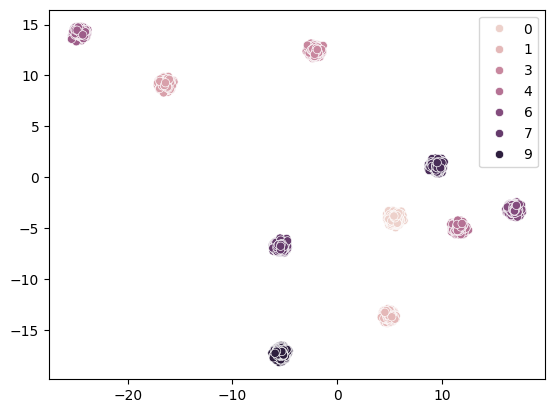

In [9]:
n_real = 10000
dim = 2

# means = stats.norm.rvs(size=(10, 2), loc=0, scale=10)
means = np.array([
    [  5.46794328,  -4.08481523],
    [  4.87211875, -13.64864684],
    [-16.39432073,   9.09802249],
    [ -2.15447941,  12.46200019],
    [ 11.55784483,  -4.96049923],
    [-24.60558474,  14.18020818],
    [ 16.84215967,  -3.18710751],
    [ -5.47807206,  -6.77247129],
    [  9.46726546,   1.05922347],
    [ -5.40346201, -17.29490131]
])
scales = np.ones((10, dim)) * 0.25
data, clusters = sample_gaussian_mixture(means, scales, np.ones(10) / 10, n_real, return_clusters=True) 

sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=clusters)
plt.savefig("../figures/gaussian_mixture_mode_dropping_invention_components.pdf")
plt.show()

In [ ]:
means

array([[  5.46794328,  -4.08481523],
       [  4.87211875, -13.64864684],
       [-16.39432073,   9.09802249],
       [ -2.15447941,  12.46200019],
       [ 11.55784483,  -4.96049923],
       [-24.60558474,  14.18020818],
       [ 16.84215967,  -3.18710751],
       [ -5.47807206,  -6.77247129],
       [  9.46726546,   1.05922347],
       [ -5.40346201, -17.29490131]])

# Sphere vs. Torus

In [14]:
def sample_unit_hypersphere_single(dim):
    while True:
        attempt = np.random.uniform(-1, 1, dim)
        if np.sum(attempt**2) <= 1:
            return attempt

def sample_hypersphere(size, dim, center, radius):
    result = np.zeros((size, dim))
    for i in range(size):
        result[i, :] = sample_unit_hypersphere_single(dim)

    result *= radius 
    result += center
    return result

def sample_torus(size):
    angles = np.random.uniform(0, 2 * np.pi, size)
    circle_points = sample_hypersphere(size, 2, np.array((1, 0)), 0.1)
    circle_points_3d = np.zeros((size, 3))
    circle_points_3d[:, 0] = circle_points[:, 0]
    circle_points_3d[:, 2] = circle_points[:, 1]

    rotations = Rotation.from_euler("z", angles)
    rotated = rotations.apply(circle_points_3d)
    return rotated

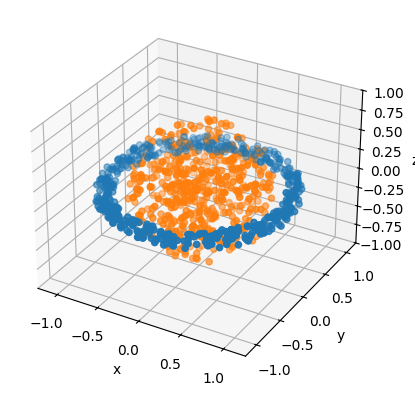

In [19]:
n = 500

torus = sample_torus(n)
sphere = sample_hypersphere(n, 3, 0, 0.8)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(torus[:, 0], torus[:, 1], torus[:, 2])
ax.scatter(sphere[:, 0], sphere[:, 1], sphere[:, 2])
ax.set_zlim(-1, 1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.savefig("../figures/sphere-torus-samples.pdf")
plt.show()

# One vs. Two Modes

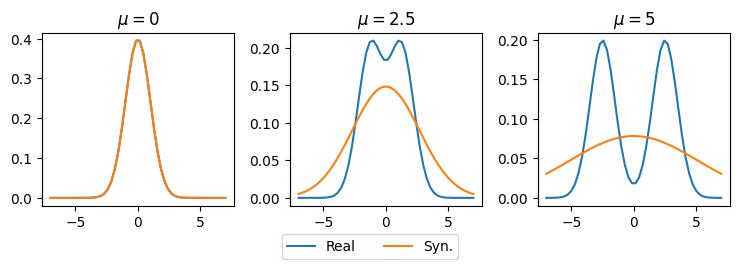

In [20]:
dim = 1

# mu_list = [0, 1, 2, 3, 4, 5]
mu_list = [0, 2.5, 5]

fig, axes = plt.subplots(1, len(mu_list), figsize=(2.5 * len(mu_list), 2.5))
for i, mu in enumerate(mu_list):
    ax = axes[i]
    xs = np.linspace(-7, 7)
    real_pdf = 0.5 * stats.norm.pdf(xs, loc=-0.5 * mu, scale=1) + 0.5 * stats.norm.pdf(xs, loc=0.5 * mu, scale=1)
    syn_pdf = stats.norm.pdf(xs, loc=0, scale=np.sqrt(1 + mu**2))
    ax.plot(xs, real_pdf, label="Real")
    ax.plot(xs, syn_pdf, label="Syn.")
    ax.set_title("$\mu = {}$".format(mu))
    if i == 0:
        leg_info = ax.get_legend_handles_labels()

fig.legend(*leg_info, loc="upper center", bbox_to_anchor=(0.5, 0.07), ncol=3)
plt.tight_layout()
plt.savefig("../figures/one_vs_two_modes_pdf_visualisation.pdf", bbox_inches="tight")
plt.show()